2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。

データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。



### 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。
$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$
a
i
,
j
,
m
 : 出力される配列のi行j列、mチャンネルの値


i
 : 配列の行方向のインデックス


j
 : 配列の列方向のインデックス


m
 : 出力チャンネルのインデックス


K
 : 入力チャンネル数


F
h
,
F
w
 : 高さ方向（h）と幅方向（w）のフィルタのサイズ


x
(
i
+
s
)
,
(
j
+
t
)
,
k
 : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


w
s
,
t
,
k
,
m
 : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


b
m
 : mチャンネルへの出力のバイアス項


全てスカラーです。

次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$
α
 : 学習率


∂
L
∂
w
s
,
t
,
k
,
m
 : 
w
s
,
t
,
k
,
m
 に関する損失 
L
 の勾配


∂
L
∂
b
m
 : 
b
m
 に関する損失 
L
 の勾配

勾配 
∂
L
∂
w
s
,
t
,
k
,
m
 や 
∂
L
∂
b
m
 を求めるためのバックプロパゲーションの数式が以下である。
 $$
 \frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

∂
L
∂
a
i
 : 勾配の配列のi行j列、mチャンネルの値


N
o
u
t
,
h
,
N
o
u
t
,
w
 : 高さ方向（h）と幅方向（w）の出力のサイズ

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max())#1.0
print(X_train.min())#0.0

1.0
0.0


In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [6]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(
             X_train , y_train_one_hot , test_size = 0.20)
print(X_train.shape)
print(X_val.shape)

(48000, 28, 28)
(12000, 28, 28)


In [7]:
X_train = X_train.reshape(-1 , 1 , 28 , 28)
X_val = X_val.reshape(-1 , 1 , 28 , 28)
X_test = X_test.reshape(-1 , 1 , 28 , 28)

In [8]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [11]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

In [12]:
mini_X_train.shape

(20, 1, 28, 28)

In [13]:
N,C,H,W = X_train.shape
print("N" , N)
print("C" , C)
print("H" , H)
print("W" , W)

N 48000
C 1
H 28
W 28


In [14]:
def im2col(X , filter_h , filter_w , stride=1,pad=0):
    N , C , H , W = X.shape
    out_h = (H + 2*pad - filter_h) // stride + 1 #割り切れない場合の丸め込み
    out_w = (W + 2*pad - filter_w) // stride + 1
    
    img = np.pad(X , [(0,0),(0,0),(pad,pad),(pad,pad)] , "constant")
    col = np.zeros((N , C , filter_h , filter_w , out_h , out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[: , : , y , x , : , :] = img[: , : , y:y_max:stride, x:x_max:stride]

    col = col.transpose(0 , 4 , 5 , 1 , 2 , 3).reshape(N*out_h*out_w, -1)#(N,C,FH,FW,OH,OW)
                                                                                                                         #(N,OH,OW,C,FH,FW)へtranspose
    return col

In [15]:
c =  im2col(X_train , 3 , 3)

In [16]:
def col2im(dcol , X , filter_h , filter_w , stride=1 , pad=0):
    N , C , H , W = X.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = dcol.reshape(N , out_h , out_w , C , filter_h , filter_w).transpose(0,3,4,5,1,2)
    
    img = np.zeros((N , C , H + 2*pad + stride-1 , W + 2*pad + stride-1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[: , : , y:y_max:stride , x:x_max:stride] += col[: , : , y , x , : , :]
            
    return img[: , : , pad:H+pad , pad:W+pad]

In [17]:
class Conv2d:
    def __init__(self , W , B ,  stride=1 , pad=0 ):
        self.W = W
        self.B = B
        self.stride = stride
        self.pad = pad
        
        
        #中間データ(backward時に使用)
        self.col = None
        self.col_W = None
        
        #重み.バイアスパラメータの勾配
        self.dW = None
        self.dB = None
        self.hw = 0
        self.hb = 0

    def _out_h(self , H , FH , pad_h=0 , stride_h=1):
        self.out_h = int(H + 2*pad_h - FH // stride_h+1)
        return self.out_h        

    def _out_w(self , W , FW , pad_w=0 , stride_w=1):
        self.out_w = int(W + 2*pad_w - FW // stride_w+1)
        return self.out_w
    
    def _im2col(self , X , FH , FW):
        N , C , H , W = X.shape
        out_h = self._out_h(H , W)
        out_w = self._out_w(W , FW)

        img = np.pad(X , [(0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)] , "constant")
        col = np.zeros((N , C , FH , FW , out_h , out_w))

        for y in range(FH):
            y_max = y + self.stride*out_h
            for x in range(FW):
                x_max = x + self.stride*out_w
                col[: , : , y , x , : , :] = img[: , : , y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0 , 4 , 5 , 1 , 2 , 3).reshape(N*out_h*out_w, -1)#(N,C,FH,FW,OH,OW)
                                                                                                                             #(N,OH,OW,C,FH,FW)へtranspose
        return col

    def _col2im(self , dcol , X , FH , FW):
        N , C , H , W = self.X.shape
        out_h = self._out_h(H , FH)
        out_w = self._out_w(W , FW)
        col = dcol.reshape(N , out_h , out_W , C , FH , FW).transpose(0,3,4,5,1,2)

        img = np.zeros(N , C , H , 2*self.pad + self.stride-1 , W + 2*self.pad + self.stride-1)
        for y in range(FH):
            y_max = y + self.stride*out_h
            for x in range(FW):
                x_max = x + self.stride*out_w
                img[: , : , y:y_max:self.stride , x:x_max:self.stride] += col[: , : , y , x , : , :]

        return img[: , : , pad:H+pad , pad:W+pad]
    
    
    
    
    
    def forward(self , X):
        FN , C , FH , FW = self.W.shape
        N , C , H , W = X.shape
        out_h = self._out_h(H , FH)
        out_w = self._out_w(W , FW)
        
        col = self._im2col(X , FH , FW)
        col_W = self.W.reshape(FN , -1).T
        
        A = np.dot(col , col_W) + self.B
        A = A.reshape(N , out_h , out_w , -1).transpose(0 , 3 , 1 , 2)
        
        self.X = X
        self.col = col
        self.col_W = col_W
        
        return A
    
    def backward(self , dA):
        FN , C , FH , FW = self.W.shape
        dA = dA.transpose(0 , 2 , 3 , 1).reshape(-1 , FN)
        
        self.dB = np.sum(dA , axis = 0)
        self.dW = np.dot(self.col.T , dA)
        self.dW = self.dW.transpose(1 , 0).reshape(FN , C , FH ,FW)
        
        dcol = np.dot(dA , self.col_W.T)
        dX = _col2im(dcol , X  , FH , FW)
        
        return dX

In [18]:
n = np.arange(16).reshape(4,4)
print("n",n)
fw = 3
fh = 3
x_hot = np.zeros([2,2,3,3])

n [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [19]:
for i in range(2):#FH
    for k in range(2):#FW
        x_hot[i , k , : , :] = n[i:i+fw , k:k+fh]
print(x_hot)

[[[[ 0.  1.  2.]
   [ 4.  5.  6.]
   [ 8.  9. 10.]]

  [[ 1.  2.  3.]
   [ 5.  6.  7.]
   [ 9. 10. 11.]]]


 [[[ 4.  5.  6.]
   [ 8.  9. 10.]
   [12. 13. 14.]]

  [[ 5.  6.  7.]
   [ 9. 10. 11.]
   [13. 14. 15.]]]]


In [20]:
class AdaGrad():
    def __init__(self , lr):
        self.lr = lr
        self.hw = None
        self.hb = None
    
    def update(self , layer):
#         layer.W = self.W
#         layer.B = self.B
#         layer.dW = self.dW
#         layer.dB = self.dB
        
        layer.hw += (layer.dW) * (layer.dW)
        layer.W -= self.lr * (layer.dW) / (np.sqrt(layer.hw) + 1e-7)
        layer.hb += (layer.dB) * (layer.dB)
        layer.B -= self.lr * (layer.dB) / (np.sqrt(layer.hb) + 1e-7)
        self.hw = layer.hw
        self.hb = layer.hb
        return layer.W, layer.B

In [21]:
class XavierInitializer():
    def __init__(self, filter_num,filter_size):
        self.n_nodes1 = filter_num
        self.n_nodes2 = filter_size        
    
    def W(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num, self.filter_size)
        return self.W
    
    def B(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.B = sigma * np.random.randn(self.filter_num)
        return self.B

In [22]:
class SimpleInitializer():

    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, filter_num, filter_size):
        W = self.sigma * np.random.randn(filter_num , filter_size)
        
        return W
    def B(self, filter_size):
        B = self.sigma * np.random.randn(filter_size)
        
        return B

In [23]:
class ReLU():
    def __init__(self):
        self.mask = None
        
    def forward(self , x):
        self.mask = (x <= 0)
        self.A = x.copy()
        self.A[self.mask] = 0
        return self.A
        
    def backward(self , dA):
        dA[self.mask] = 0
        dA = dA
        return dA

【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

In [24]:
def out_h(H , FH , stride_h=1 , pad_h=0):
    int(H + 2*pad_h - FH // stride_h+1)
    return out_h

In [25]:
def out_w(W , FW , stride_w=1 , pad_w=0):
    int(W + 2*pad_w - FW // stride_w+1)
    return out_w

【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。
$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$
P
i
,
j
  : i行j列への出力する場合の入力配列のインデックスの集合。 
S
h
×
S
w
 の範囲内の行（p）と列（q）


S
h
,
S
w
 : 高さ方向（h）と幅方向（w）のストライドのサイズ


(
p
,
q
)
∈
P
i
,
j
 : 
P
i
,
j
 に含まれる行（p）と列（q）のインデックス


a
i
,
j
,
m
 : 出力される配列のi行j列、kチャンネルの値


x
p
,
q
,
k
 : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス 
(
p
,
q
)
 を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。



In [26]:
class MaxPool2D:
    def __init__(self , pool_h , pool_w , stride=2 , pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.X = None
        self.arg_max = None
        
        
#     def _out_h(self , H , FH , pad_h=0 , stride_h=1):
#         self.out_h = int(H + 2*pad_h - FH // stride_h+1)
#         return self.out_h        

#     def _out_w(self , W , FW , pad_w=0 , stride_w=1):
#         self.out_w = int(W + 2*pad_w - FW // stride_w+1)
#         return self.out_w
        
    def _im2col(self , X , FH , FW):
        N , C , H , W = X.shape
        out_h = (H + 2*self.pad - FH)//self.stride + 1
        out_w = (W + 2*self.pad - FW)//self.stride + 1

        img = np.pad(X , [(0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)] , "constant")
        col = np.zeros((N , C , FH , FW , out_h , out_w))

        for y in range(FH):
            y_max = y + self.stride*out_h
            for x in range(FW):
                x_max = x + self.stride*out_w
                col[: , : , y , x , : , :] = img[: , : , y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0 , 4 , 5 , 1 , 2 , 3).reshape(N*out_h*out_w, -1)#(N,C,FH,FW,OH,OW)
                                                                                                                             #(N,OH,OW,C,FH,FW)へtranspose
        return col
    
    def _col2im(self , dcol , X , FH , FW):
        N , C , H , W = X.shape
        out_h = (H + 2*self.pad - FH)//self.stride + 1
        out_w = (W + 2*self.pad - FW)//self.stride + 1
        col = dcol.reshape(N , out_h , out_w , C , FH , FW).transpose(0,3,4,5,1,2)

        img = np.zeros((N , C , H + 2*self.pad + self.stride-1 , W + 2*self.pad + self.stride-1))
        for y in range(FH):
            y_max = y + self.stride*out_h
            for x in range(FW):
                x_max = x + self.stride*out_w
                img[: , : , y:y_max:self.stride , x:x_max:self.stride] += col[: , : , y , x , : , :]

        return img[: , : , self.pad:H+self.pad , self.pad:W+self.pad]
    
        
    
        
    def forward(self , X):
        N , C , H , W = X.shape
        out_h = int((H - self.pool_h) // self.stride + 1)
        out_w = int((W - self.pool_w) // self.stride + 1)
        
        col = self._im2col(X , self.pool_h , self.pool_w)
        col = col.reshape(-1 , self.pool_h * self.pool_w)
        
        arg_max = np.argmax(col , axis = 1)
        A = np.max(col , axis=1)
        A = A.reshape(N , out_h , out_w , C).transpose(0 , 3 , 1 , 2)
        
        self.X = X
        self.arg_max = arg_max
        
        return A
        
    def backward(self , dA):
        dA = dA.transpose(0 , 2 , 3 , 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dA.size , pool_size))
        dmax[np.arange(self.arg_max.size) , self.arg_max.flatten()] = dA.flatten()
        dmax = dmax.reshape(dA.shape + (pool_size , ))

        dcol = dmax.reshape(dA.shape[0] * dmax.shape[1] * dmax.shape[2] , -1)
        dX = self._col2im(dcol , self.X , self.pool_h , self.pool_w )

        return dX

In [27]:
pool = MaxPool2D(2,2)

In [28]:
a = pool.forward(mini_X_train)
a.shape

(20, 1, 14, 14)

【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [29]:
class Flatten:
    
    def forward(self , X):
        self.X = X
        N , C , H , W = self.X.shape
        a = self.X.reshape(N , -1)
        return a 
    
    def backward(self , da):
        x = self.X.shape
        da = da.reshape(x)
        return da

In [30]:
f = Flatten()
d = f.forward(mini_X_train)

In [31]:
f.backward(d).shape

(20, 1, 28, 28)

検証

【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。



In [32]:
class FC():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2 , initializer, optimizer , sigma=0.01):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.sigma = sigma
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1 , self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        self.X = None
        self.dW = None
        self.dB = None
        self.hw = 0
        self.hb = 0
        
        
        
#         self.W = self.sigma * self.initializer.W(self.n_nodes1 , self.n_nodes2)
#         self.B = self.sigma * self.initializer.B(self.n_nodes2)
#         self.W2 = self.sigma * self.initializer.W(self.n_nodes1 , self.n_nodes2)
#         self.B2 = self.initializer.B(self.n_nodes2)
#         self.W_out = self.sigma * self.initializer.W(self.n_nodes2 , self.n_output)
#         self.B_out = self.initializer.B(self.n_output)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """   
        self.X = X
        self.A = np.dot(self.X , self.W) + self.B
        
        return self.A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.dW = np.dot(self.X.T , dA)
        self.dB = np.sum(dA , axis = 0)
        dZ = np.dot(dA , self.W.T)
        # 更新
        self = self.optimizer.update(self)
        return dZ

In [33]:
class HeInitializer():
    def __init__(self , n_filter , n_channels , filter_h , filter_w):
        self.n_filter = n_filter
        self.n_channels = n_channels
        self.filter_h = filter_h
        self.filter_w  = filter_w
    
    def W(self):
        sigma =  np.sqrt(2.0 / self.n_channels)
        self.W = sigma * np.random.randn(self.n_filter , self.n_channels , self.filter_h , self.filter_w)
        return self.W
    
    def B(self):
        sigma =  np.sqrt(2.0 / self.n_channels)
        self.B = sigma * np.random.randn(self.n_filter)
        return self.B

In [34]:
class Conv2d:
    def __init__(self , stride=1 , pad=0 , initializer=HeInitializer(20,1,28,28), optimizer=AdaGrad(lr=0.01)):
#         self.W = W
#         self.B = B
        self.stride = stride
        self.pad = pad
        
        
        #中間データ(backward時に使用)
        self.col = None
        self.col_W = None
        
        #重み.バイアスパラメータの勾配
        self.dW = None
        self.dB = None
        self.hw = 0
        self.hb = 0
        self.initializer = initializer
        self.optimizer = optimizer

    def _out_h(self , H , FH , pad_h=0 , stride_h=1):
        self.out_h = int(H + 2*pad_h - FH // stride_h+1)
        return self.out_h        

    def _out_w(self , W , FW , pad_w=0 , stride_w=1):
        self.out_w = int(W + 2*pad_w - FW // stride_w+1)
        return self.out_w
    
    def _im2col(self , X , FH , FW):
        N , C , H , W = X.shape
        out_h = self._out_h(H , FH)
        out_w = self._out_w(W , FW)

        img = np.pad(X , [(0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)] , "constant")
        col = np.zeros((N , C , FH , FW , out_h , out_w))

        for y in range(FH):
            y_max = y + self.stride*out_h
            for x in range(FW):
                x_max = x + self.stride*out_w
                col[: , : , y , x , : , :] = img[: , : , y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0 , 4 , 5 , 1 , 2 , 3).reshape(N*out_h*out_w, -1)#(N,C,FH,FW,OH,OW)
                                                                                                                             #(N,OH,OW,C,FH,FW)へtranspose
        return col

    def _col2im(self , dcol , X , FH , FW):
        N , C , H , W = self.X.shape
        out_h = self._out_h(H , W)
        out_w = self._out_w(W , FW)
        col = dcol.reshape(N , out_h , out_W , C , FH , FW).transpose(0,3,4,5,1,2)

        img = np.zeros(N , C , H , 2*self.pad + self.stride-1 , W + 2*self.pad + self.stride-1)
        for y in range(FH):
            y_max = y + self.stride*out_h
            for x in range(FW):
                x_max = x + self.stride*out_w
                img[: , : , y:y_max:self.stride , x:x_max:self.stride] += col[: , : , y , x , : , :]

        return img[: , : , pad:H+pad , pad:W+pad]
    
    
    
    
    
    def forward(self , X):
        self.W = self.initializer.W()
        self.B = self.initializer.B()
        FN , C , FH , FW = self.W.shape
        N , C , H , W = X.shape
        out_h = self._out_h(H , FH)
        out_w = self._out_w(W , FW)
        
        col = self._im2col(X , FH , FW)
        col_W = self.W.reshape(FN , -1).T
        
        A = np.dot(col , col_W) + self.B
        A = A.reshape(N , out_h , out_w , -1).transpose(0 , 3 , 1 , 2)
        
        self.X = X
        self.col = col
        self.col_W = col_W
        
        return A
    
    def backward(self , dA):
        FN , C , FH , FW = self.W.shape
        dA = dA.transpose(0 , 2 , 3 , 1).reshape(-1 , FN)
        
        self.dB = np.sum(dA , axis = 0)
        self.dW = np.dot(self.col.T , dA)
        self.dW = self.dW.transpose(1 , 0).reshape(FN , C , FH ,FW)
        dcol = np.dot(dA , self.col_W.T)
        dX = col2im(dcol , self.X  , FH , FW)
        
        
        self = self.optimizer.update(self)
        return dX

In [35]:
c = Conv2d()

In [37]:
a = c.forward(mini_X_train)

In [38]:
c.backward(a).shape

(20, 1, 28, 28)

In [39]:
class _Conv2d:
    def __init__(self , W , B  , stride=1 , pad=0 , optimizer=AdaGrad(lr=0.01)):
        self.W = W
        self.B = B
        self.stride = stride
        self.pad = pad
        
        
        #中間データ(backward時に使用)
        self.col = None
        self.col_W = None
        
        #重み.バイアスパラメータの勾配
        self.dW = None
        self.dB = None
        self.hw = 0
        self.hb = 0
#         self.initializer = initializer
        self.optimizer = optimizer

    def _out_h(self , H , FH , pad_h=0 , stride_h=1):
        self.out_h = int(H + 2*pad_h - FH // stride_h+1)
        return self.out_h        

    def _out_w(self , W , FW , pad_w=0 , stride_w=1):
        self.out_w = int(W + 2*pad_w - FW // stride_w+1)
        return self.out_w
    
    def _im2col(self , X , FH , FW):
        N , C , H , W = X.shape
        out_h = self._out_h(H , FH)
        out_w = self._out_w(W , FW)

        img = np.pad(X , [(0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)] , "constant")
        col = np.zeros((N , C , FH , FW , out_h , out_w))

        for y in range(FH):
            y_max = y + self.stride*out_h
            for x in range(FW):
                x_max = x + self.stride*out_w
                col[: , : , y , x , : , :] = img[: , : , y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0 , 4 , 5 , 1 , 2 , 3).reshape(N*out_h*out_w, -1)#(N,C,FH,FW,OH,OW)
                                                                                                                             #(N,OH,OW,C,FH,FW)へtranspose
        return col

    def _col2im(self , dcol , X , FH , FW):
        N , C , H , W = self.X.shape
        out_h = self._out_h(H , FH)
        out_w = self._out_w(W , FW)
        col = dcol.reshape(N , out_h , out_W , C , FH , FW).transpose(0,3,4,5,1,2)

        img = np.zeros(N , C , H , 2*self.pad + self.stride-1 , W + 2*self.pad + self.stride-1)
        for y in range(FH):
            y_max = y + self.stride*out_h
            for x in range(FW):
                x_max = x + self.stride*out_w
                img[: , : , y:y_max:self.stride , x:x_max:self.stride] += col[: , : , y , x , : , :]

        return img[: , : , pad:H+pad , pad:W+pad]
    
    
    
    
    
    def forward(self , X):
        FN , C , FH , FW = self.W.shape
        N , C , H , W = X.shape
        out_h = self._out_h(H , FH)
        out_w = self._out_w(W , FW)
        
        col = self._im2col(X , FH , FW)
        col_W = self.W.reshape(FN , -1).T
        
        A = np.dot(col , col_W) + self.B
        A = A.reshape(N , out_h , out_w , -1).transpose(0 , 3 , 1 , 2)
        self.X = X
        self.col = col
        self.col_W = col_W
        
        return A
    
    def backward(self , dA):
        FN , C , FH , FW = self.W.shape
        dA = dA.transpose(0 , 2 , 3 , 1).reshape(-1 , FN)
        
        self.dB = np.sum(dA , axis = 0)
        self.dW = np.dot(self.col.T , dA)
        self.dW = self.dW.transpose(1 , 0).reshape(FN , C , FH ,FW)
        
        dcol = np.dot(dA , self.col_W.T)
        dX = col2im(dcol , self.X  , FH , FW)
        
        
        self = self.optimizer.update(self)
        return dX
    
class SGD():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
#         layer.W = self.W
#         layer.B = self.B
#         layer.dW = self.dW
#         layer.dB = self.dB
        
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer.W , layer.B
    
class AdaGrad():
    def __init__(self , lr):
        self.lr = lr
        self.hw = None
        self.hb = None
    
    def update(self , layer):
#         layer.W = self.W
#         layer.B = self.B
#         layer.dW = self.dW
#         layer.dB = self.dB
        
        layer.hw += (layer.dW) * (layer.dW)
        layer.W -= self.lr * (layer.dW) / (np.sqrt(layer.hw) + 1e-7)
        layer.hb += (layer.dB) * (layer.dB)
        layer.B -= self.lr * (layer.dB) / (np.sqrt(layer.hb) + 1e-7)
        self.hw = layer.hw
        self.hb = layer.hb
        return layer.W, layer.B  

class SoftmaxWithLoss():
    def __init__(self):
        self.loss = None
        self.y = None
        
        
    def forward(self , x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))
    
    def backward(self , z , y):
        self.dA = z - y
        return self.dA
    
    def Loss(self , z , y):
        loss =  -np.sum(y * np.log(z) + 1e-7) / y.shape[0]
        return loss


In [40]:
class Affine:
    def __init__(self , W ,B):
        self.W = W
        self.B = B
        self.X = None
        self.dW = None
        self.dB = None
        
    def forward(self , X):
        self.X = X
        A = np.dot(X , self.W) + self.B
        return A
    
    def backward(self , dA):
        dZ = np.dot(dA , self.W.T)
        self.dW = np.dot(self.X.T , dA)
        self.dB = np.sum(dA , axis=0)
        return dZ


In [41]:
class CNN():

    def __init__(self,F_num = 30 ,C =1, FW = 3 , FH = 3 , pool_w = 2, pool_h = 2 ,pad = 0 ,stride = 1 ,
                            epochs = 1,lr = 0.001 ,sigma = 0.01,n_nodes1= 400 , n_nodes2 = 200 , n_output = 10 ,
                             batch_size = 20, verbose = True):
        self.verbose = verbose
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        n_features = X_train.shape[1]
        self.n_features = n_features
        self.batch_size = batch_size
        self.lr = lr
        self.loss = []
        self.epochs = epochs
        self.F_num = F_num
        self.C = C
        self.FW = FW
        self.FH = FH
        self.pool_w = pool_w
        self.pool_h = pool_h
        self.pad = pad
        self.stride = stride
        N , C , H , W = X_train.shape
        out_h = int(H + 2*self.pad - self.FH // self.stride+1)
        out_w = int(H + 2*self.pad - self.FH // self.stride+1)
        out_h2 = out_h // self.pool_h
        out_w2 = out_w //  self.pool_w
        self.num = int(self.F_num * C * out_h2 * out_w2)

    def fit(self, X, y, X_val=None, y_val=None):
   
        Xavi = HeInitializer(self.F_num , self.C , self.FW , self.FH)
        self.W = Xavi.W()
        self.B = Xavi.B()
        optimizer = AdaGrad(self.lr)
        self.Con = _Conv2d(self.W,self.B)
        self.pool = MaxPool2D(self.pool_h , self.pool_w)
        self.activation1 = ReLU()
        self.fla   = Flatten()
        self.FC =  FC(self.num  , self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = SoftmaxWithLoss()
        
        
        for i in range(self.epochs):
            self.get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
            for self.mini_X_train, self.mini_y_train in get_mini_batch:
                A1 = self.Con.forward(self.mini_X_train)
                A2 = self.pool.forward(A1)
                Z1 = self.activation1.forward(A2)
                F =  self.fla.forward(Z1)
                A3 = self.FC.forward(F)
                Z3 = self.activation2.forward(A3)
                
                dA3 = self.activation2.backward(Z3 , self.mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC.backward(dA3)
                dF =  self.fla.backward(dZ2)
#                 sA2 = self.Fla.backward(dZ2)
                dA2 = self.activation1.backward(dF)
                dA1 = self.pool.backward(dA2)
                dZ1 = self.Con.backward(dA1)
#                 dA1 = self.activation1.backward(dZ1)
#                 dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                self.c_loss = self.activation2.Loss(Z3 , self.mini_y_train)
            self.loss = np.append(self.loss , self.c_loss)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()

    def _predict(self, X):
        A1 = self.Con.forward(X)
        A2 = self.pool.forward(A1)
        Z1 = self.activation1.forward(A2)
        F =  self.fla.forward(Z1)
        A3 = self.FC.forward(F)
        Z3 = self.activation2.forward(A3)
        self.y_pred = np.argmax(Z3 , axis = 1)
        return self.y_pred
    
    def accuracy(self , X , t):
        y_pred = self._predict(X)
        return np.sum(y_pred == t) / float(X.shape[0])

In [42]:
cnn = CNN(epochs = 3,lr = 0.001)

In [44]:
cnn.fit(X_train , y_train)

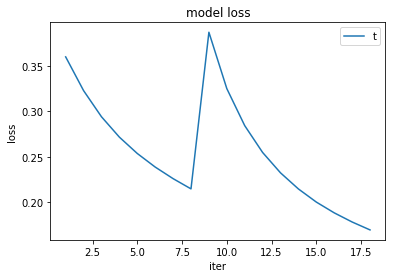

In [45]:
plt.plot(np.arange(1 , len(cnn.loss) + 1) , cnn.loss , label = "loss")
# plt.plot(np.arange(1 , len(slr.val_loss) + 1) , slr.val_loss , label = "test_loss")
plt.title("model loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend("train_loss")
plt.show()

In [46]:
cnn._predict(X_test)

array([7, 2, 1, ..., 4, 5, 6])

In [47]:
cnn.accuracy(X_test , y_test)

0.9705

【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。



入力サイズ : 144×144, 3チャンネル フィルタサイズ : 3×3, 6チャンネル ストライド : 1 パディング : なし

In [48]:
#出力数
OH = (144 + 2*0-3) / 1 + 1
OW = (144 + 2*0 -3) / 1+ 1
print("0H , OW"  , OH , OW)

#パラメータ数
#param = FH * FW *I_C * O_C + B
print(3 * 3 * 3 + 6 + 6)

0H , OW 142.0 142.0
39


入力サイズ : 60×60, 24チャンネル フィルタサイズ : 3×3, 48チャンネル ストライド　: 1 パディング : なし

In [49]:
#出力数
OH = (60 + 2*0-3) / 1 + 1
OW = (60 + 2*0-3) / 1 + 1
print("0H , OW"  , OH , OW)

#パラメータ数
print(3*3*24*48+48)

0H , OW 58.0 58.0
10416


入力サイズ : 20×20, 10チャンネル フィルタサイズ: 3×3, 20チャンネル ストライド : 2 パディング : なし

In [50]:
#出力数
OH = (20 + 2*0-3) // 2 + 1
OW = (20 + 2*0-3) // 2 + 1
print("0H , OW"  , OH , OW)

#パラメータ数
print(3*3*10*20+20)

0H , OW 9 9
1820
